In [139]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [140]:
from os import environ
environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Load and resize the images

In [141]:
IMAGE_LIB = '../../vascus/synimages/'
MASK_LIB = '../../vascus/synmasks/'
#IMAGE_LIB = '../../vascus/synimages_st1/'
#MASK_LIB = '../../vascus/synmasks_st1/'
IMAGE_VAL_LIB = '../../vascus/validation/images/'
MASK_VAL_LIB = '../../vascus/validation/masks/'

IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [142]:
#th is a threshhold for the mask [0-255]
#the lesser th is the more solid mask is

def loadImages(imglib,masklib,th):

    all_images = [x for x in sorted(os.listdir(imglib)) if x[-4:] == '.png']

    x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
    for i, name in enumerate(all_images):
        im = cv2.imread(imglib + name, cv2.IMREAD_UNCHANGED).astype("uint8")
        im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        #some normalization so values should be between 0-1
        diff = np.max(im) - np.min(im)
        #print(name + str(diff))
        if(diff!=0):
            x_data[i] = (im - np.min(im)) / diff
        else:
            x_data[i]=im/255.

    y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
    for i, name in enumerate(all_images):
        im = cv2.imread(masklib + name, cv2.IMREAD_UNCHANGED).astype('uint8')
        im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        #apply th param to the mask
        #print(np.max(im))
        ret,thresh1 = cv2.threshold(im,th,255,cv2.THRESH_BINARY)
        y_data[i] = thresh1/255.
        
    return x_data,y_data

In [143]:
x_data,y_data = loadImages(IMAGE_LIB,MASK_LIB,100)


In [144]:
x_data.shape


(328, 64, 64)

In [145]:
from sklearn.utils import shuffle

x_data, y_data = shuffle(x_data, y_data)

In [146]:
x_data.shape

(328, 64, 64)

We can do validation on some part of training set 
or we can use masks from real data
Lets move the second way

Second way:

In [147]:
valx_data,valy_data = loadImages(IMAGE_VAL_LIB,MASK_VAL_LIB,100)

In [148]:
x_train = x_data[:,:,:,np.newaxis]
y_train = y_data[:,:,:,np.newaxis]
x_val = valx_data[:,:,:,np.newaxis]
y_val = valy_data[:,:,:,np.newaxis]

First way:

In [131]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.01)

In [78]:
x_train.shape

(294, 64, 64, 1)

In [79]:
x_val.shape

(3, 64, 64, 1)

## Define and train model

In [149]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + K.epsilon())

In [139]:
def dice_loss (y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [100]:
#for 32 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [150]:
#for 64 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [162]:
#for 128 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=48, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.1)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [203]:
#for 256 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=256, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 4)    40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 4)    0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 8)    296         max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [151]:
#seed is VERY important for image and mask transform simultaneously

def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            vertical_flip=True,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=123)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            vertical_flip=True,
            zoom_range=0.1
            ).flow(y_train, y_train, batch_size, seed=123)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

Lets see what we get in training set

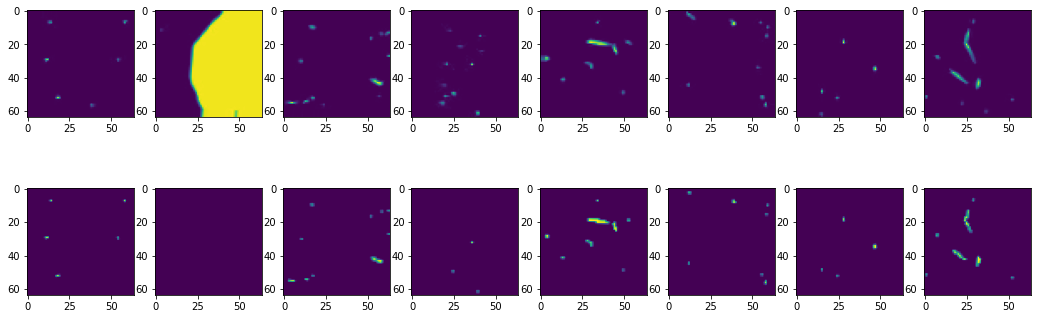

In [53]:

image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(2,8, figsize=(18,6))
for i in range(8):
    ax[0,i].imshow(image_batch[i,:,:,0])
    ax[1,i].imshow(mask_batch[i,:,:,0])
plt.show()

Lets see what we get in validation set

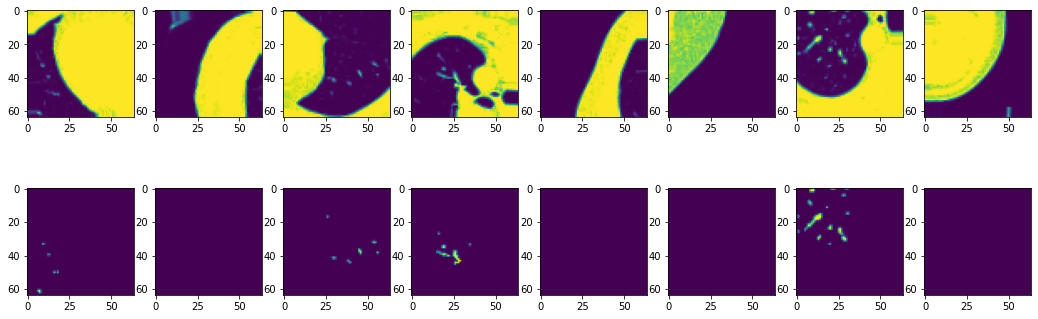

In [54]:
image_batch, mask_batch = next(my_generator(x_val, y_val, 8))
fix, ax = plt.subplots(2,8, figsize=(18,6))
for i in range(8):
    ax[0,i].imshow(image_batch[i,:,:,0])
    ax[1,i].imshow(mask_batch[i,:,:,0])
plt.show()

Lets compile and fit the model

In [152]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [120]:
#We can try SGD to compare with Adam
from keras.optimizers import SGD
opt = SGD(lr=0.0002)
model.compile(loss = "binary_crossentropy", optimizer = opt,metrics=[dice_coef])

In [51]:
weight_saver = ModelCheckpoint('../../models/save_syn64_best.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [153]:
callbacks = [
    keras.callbacks.ModelCheckpoint("../../models/save_syn64_dice_{epoch}.h5"),
]

In [154]:
batch_size=8
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = int(x_train.shape[0]/batch_size)+1,
                           validation_data = (x_val, y_val),
                           epochs=200, 
                           #callbacks = [weight_saver])
                           #callbacks = [weight_saver, annealer]) #this does not work!!
                           callbacks = callbacks)

Epoch 1/200


INFO:plaidml:Analyzing Ops: 127 of 448 operations complete


42/42 [==============================] - 30s 712ms/step - loss: 0.6567 - dice_coef: 0.0192 - val_loss: 0.5315 - val_dice_coef: 0.0187
Epoch 2/200
42/42 [==============================] - 1s 32ms/step - loss: 0.3401 - dice_coef: 0.0175 - val_loss: 0.0739 - val_dice_coef: 0.0027
Epoch 3/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0753 - dice_coef: 0.0051 - val_loss: 0.0743 - val_dice_coef: 0.0013
Epoch 4/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0695 - dice_coef: 0.0051 - val_loss: 0.0714 - val_dice_coef: 0.0014
Epoch 5/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0609 - dice_coef: 0.0066 - val_loss: 0.0661 - val_dice_coef: 0.0014
Epoch 6/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0585 - dice_coef: 0.0062 - val_loss: 0.0571 - val_dice_coef: 0.0014
Epoch 7/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0517 - dice_coef: 0.0092 - val_loss: 0.0476 - val_dice_coef: 0.0015
Ep

42/42 [==============================] - 1s 32ms/step - loss: 0.0079 - dice_coef: 0.8461 - val_loss: 0.0115 - val_dice_coef: 0.6611
Epoch 58/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0091 - dice_coef: 0.8486 - val_loss: 0.0108 - val_dice_coef: 0.6288
Epoch 59/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0082 - dice_coef: 0.8539 - val_loss: 0.0114 - val_dice_coef: 0.6059
Epoch 60/200
42/42 [==============================] - 1s 31ms/step - loss: 0.0078 - dice_coef: 0.8532 - val_loss: 0.0112 - val_dice_coef: 0.6273
Epoch 61/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0086 - dice_coef: 0.8403 - val_loss: 0.0114 - val_dice_coef: 0.6637
Epoch 62/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0084 - dice_coef: 0.8428 - val_loss: 0.0106 - val_dice_coef: 0.6435
Epoch 63/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0085 - dice_coef: 0.8536 - val_loss: 0.0110 - val_dice_coef: 0.682

42/42 [==============================] - 1s 32ms/step - loss: 0.0069 - dice_coef: 0.8960 - val_loss: 0.0117 - val_dice_coef: 0.7233
Epoch 114/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0073 - dice_coef: 0.9044 - val_loss: 0.0117 - val_dice_coef: 0.7261
Epoch 115/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0071 - dice_coef: 0.8993 - val_loss: 0.0119 - val_dice_coef: 0.7230
Epoch 116/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0071 - dice_coef: 0.9075 - val_loss: 0.0117 - val_dice_coef: 0.7199
Epoch 117/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0069 - dice_coef: 0.9036 - val_loss: 0.0108 - val_dice_coef: 0.6244
Epoch 118/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0072 - dice_coef: 0.8973 - val_loss: 0.0110 - val_dice_coef: 0.7081
Epoch 119/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0070 - dice_coef: 0.9073 - val_loss: 0.0115 - val_dice_coef:

Epoch 169/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0069 - dice_coef: 0.9239 - val_loss: 0.0124 - val_dice_coef: 0.6901
Epoch 170/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0068 - dice_coef: 0.9099 - val_loss: 0.0122 - val_dice_coef: 0.6710
Epoch 171/200
42/42 [==============================] - 1s 31ms/step - loss: 0.0068 - dice_coef: 0.9197 - val_loss: 0.0124 - val_dice_coef: 0.7187
Epoch 172/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0069 - dice_coef: 0.9176 - val_loss: 0.0130 - val_dice_coef: 0.5858
Epoch 173/200
42/42 [==============================] - 1s 31ms/step - loss: 0.0066 - dice_coef: 0.8995 - val_loss: 0.0121 - val_dice_coef: 0.6955
Epoch 174/200
42/42 [==============================] - 1s 31ms/step - loss: 0.0069 - dice_coef: 0.9192 - val_loss: 0.0123 - val_dice_coef: 0.6934
Epoch 175/200
42/42 [==============================] - 1s 32ms/step - loss: 0.0069 - dice_coef: 0.9129 - val_loss: 0.0124 - 

## Evaluate

In [82]:
#model.load_weights('../../models/save_lung_256_300k_50.h5')
model.load_weights('../../models/save_syn64_dicereal_90.h5')

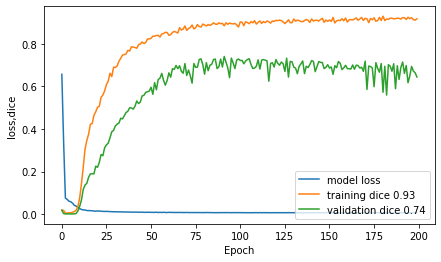

In [155]:
plt.rcParams["figure.figsize"] = (7,4)
loss_train = hist.history['loss']
dice = hist.history['dice_coef']
val_dice = hist.history['val_dice_coef']
plt.plot(loss_train)
plt.plot(dice)
plt.plot(val_dice)
plt.title('')
plt.ylabel('loss,dice')
plt.xlabel('Epoch')
plt.legend(['model loss', 'training dice '+str(round(max(hist.history['dice_coef']),2)),'validation dice '+str(round(max(hist.history['val_dice_coef']),2)) ], loc='lower right')
plt.show()

In [147]:
hist.history.keys()

dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])

In [148]:
np.size(hist.history['val_loss'])


200

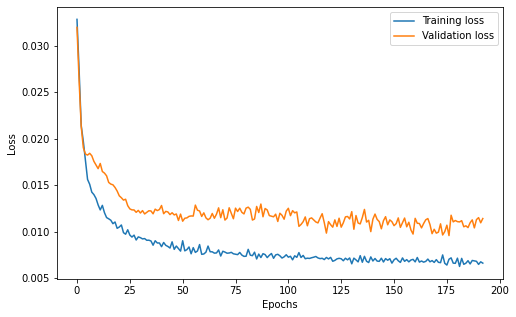

In [149]:
plt.rcParams["figure.figsize"] = (8,5)
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
plt.plot(loss_train[7:300],  label='Training loss')
plt.plot(loss_val[7:300], label='Validation loss')
#plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

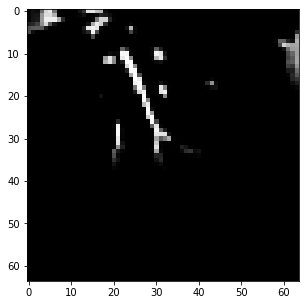

In [154]:
plt.imshow(model.predict(x_val[19].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [155]:
y_hat = model.predict(x_val)

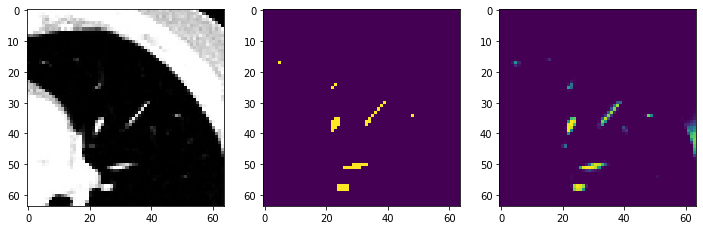

In [156]:
N=15
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[N,:,:,0], cmap='gray')
ax[1].imshow(y_val[N,:,:,0])
ax[2].imshow(y_hat[N,:,:,0])

============== TESTING ON UNKNOWN SET =================

In [157]:
IMAGE_LIB = '../../vascus/synimages_test/'
MASK_LIB = '../../vascus/synmasks_test/'
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [158]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

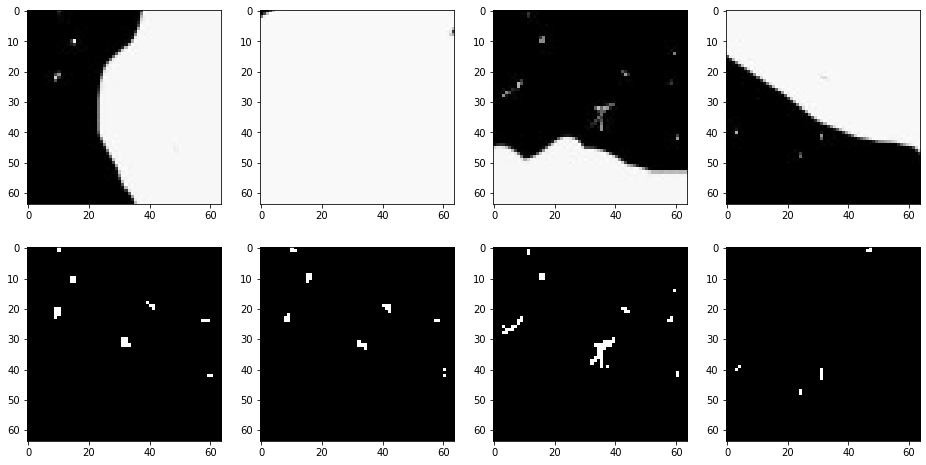

In [159]:
fig, ax = plt.subplots(2,4, figsize = (16,8))
ax[0,0].imshow(x_data[13], cmap='gray')
ax[1,0].imshow(y_data[13], cmap='gray')
ax[0,1].imshow(x_data[14], cmap='gray')
ax[1,1].imshow(y_data[14], cmap='gray')
ax[0,2].imshow(x_data[15], cmap='gray')
ax[1,2].imshow(y_data[15], cmap='gray')
ax[0,3].imshow(x_data[16], cmap='gray')
ax[1,3].imshow(y_data[16], cmap='gray')

plt.show()

In [89]:
x_test = x_data[:,:,:,np.newaxis]
y_test = y_data[:,:,:,np.newaxis]


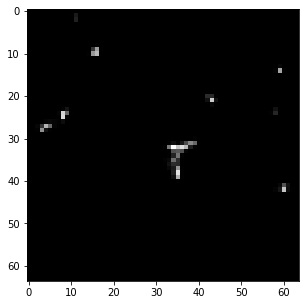

In [160]:
plt.imshow(model.predict(x_test[15].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

NOW LETS SEE IF IT WORKS ON REAL DATA

In [161]:
IMAGE_LIB = '../../lungs_ds6/norma_test/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [162]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.jpg']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("uint8")
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    #print(diff)
    if(diff>1):
        if(diff!=0):
            im = (im - np.min(im)) / diff
        else:
            im=im/255.
            
    x_data[i] = im


In [163]:
x_data.shape

(415, 256, 256)

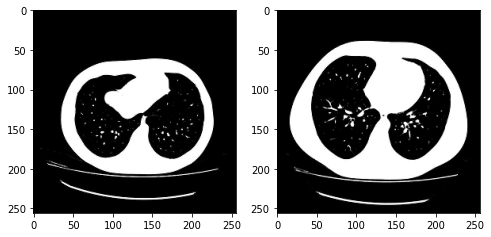

In [164]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[150], cmap='gray')
ax[1].imshow(x_data[151], cmap='gray')
plt.show()

In [165]:
#now lets make patches
from patchify import patchify, unpatchify

realimg = x_data[151]

patches = patchify(realimg, (64,64), step=64) # split image into 2*3 small 2*2 patches.

patches.shape


(4, 4, 64, 64)

In [166]:
im = patches[2,3,]

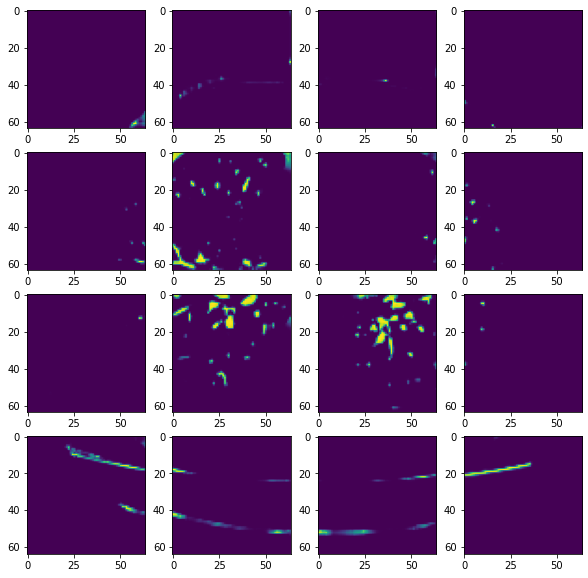

In [167]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
#plt.axis('off')
#fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ax[i,j].imshow(pred[0,:,:,0])

plt.show()



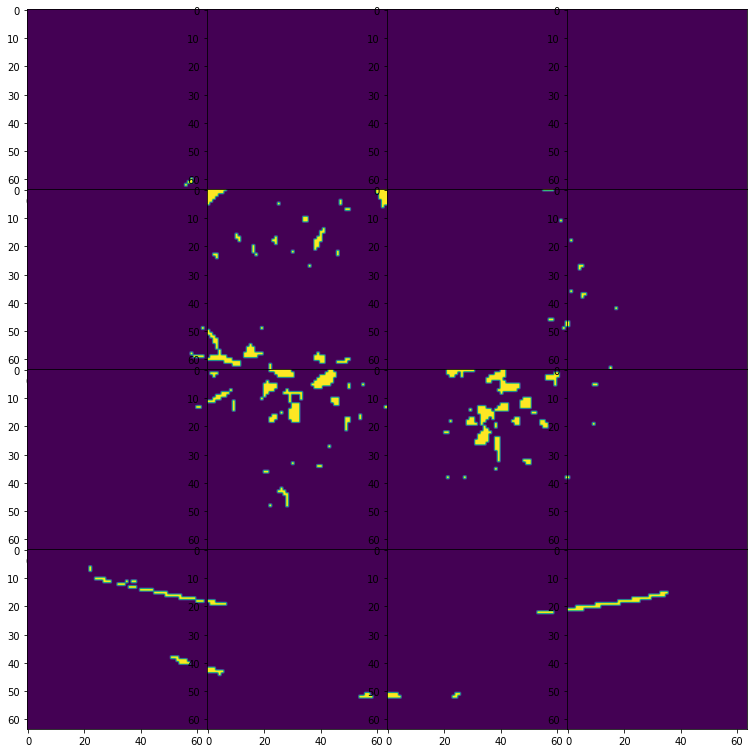

In [168]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
#plt.axis('off')
fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.5,1.0,cv2.THRESH_BINARY)
        patches[i,j,] = thresh1
        ax[i,j].imshow(thresh1)

plt.show()


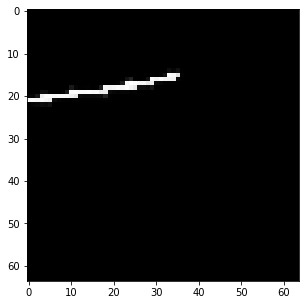

In [169]:
plt.imshow(model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [170]:
the_mask = unpatchify(patches, realimg.shape)
the_mask.shape


(256, 256)

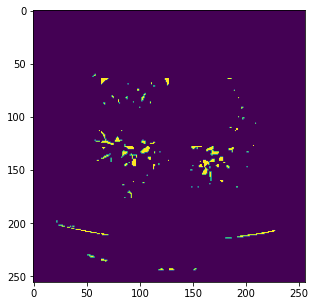

In [171]:
plt.imshow(the_mask)

=================== NOW Lets make a 3D-work ===================


In [244]:
import imageio

In [245]:
IMAGE_LIB = '../../P012/slices/'
MASK_LIB = '../../P012/vesselmasks/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [246]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    alpha=3.3
    beta=-280
    im=cv2.addWeighted(im,alpha,np.zeros(im.shape, im.dtype),0,beta)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
            
    x_data[i] = im


In [193]:
x_data.shape

(328, 64, 64, 1)

In [248]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

def procesImage(img):
    
    realimg = img.copy()
    
    patches = patchify(realimg, (IMG_HEIGHT,IMG_WIDTH), step=IMG_WIDTH)
    
    for i in range(4):
        for j in range(4):
            im = patches[i,j,] 
            pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
            ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.7,1.0,cv2.THRESH_BINARY)
            patches[i,j,] = thresh1
    
    return unpatchify(patches, realimg.shape)
    

In [249]:
masks = np.empty((x_data.shape[0], SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
N=170
#plt.imshow(x_data[N], cmap='gray')

i=-1
for img in x_data:
    i+=1
    #print(str(realimg.shape))
    #if(i!=N):
    #    continue
    #plt.imshow(img)
    themask = procesImage(img)
    #plt.imshow(themask)
    if(i>99):
        fname = ""+str(i);
    elif(i>10):
        fname = "0"+str(i);
    else:
        fname = "00"+str(i);
    #print(str(np.max(themask)))
    #plt.imshow(themask)
    themask = 255*themask
    themask = themask.astype(np.uint8)
    masks[i]=themask
    imageio.imwrite(MASK_LIB+"P012_"+fname+".png", themask)
    
print("Images saved: "+ str(i))



Images saved: 362


In [250]:
masks.shape

(363, 256, 256)

In [251]:
np.max(x_data)

1.0

In [252]:
np.max(masks)

255.0

In [253]:
np.min(masks)

0.0

In [254]:
x_data = x_data-0.8
x_data = x_data*1000
x_data = x_data.astype(np.int16)


In [255]:
np.min(x_data)

-800

In [256]:
import nibabel as nib

def rotateAndSave(arr,fname):
#we need to apply some rotations before saving to nifti
    arr = np.swapaxes(arr,0,2)
    arr = np.rot90(arr)
    arr = np.rot90(arr)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(arr,affine)

    nib.save(nifti_file, fname)
    

In [257]:
rotateAndSave(masks,MASK_LIB +"P012.nii")

In [258]:
rotateAndSave(x_data,IMAGE_LIB +"P012.nii")

In [111]:
inputfile="../../P012/slices/P012.nii"

# set fn as your 4d nifti file
nii_original_scan = nib.load(inputfile).get_fdata()
nii_original_scan.shape



(512, 512, 363)

In [ ]:
check_orientation(ct_image, ct_arr)

================== ROC-AUC =================

In [172]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [173]:
y_data.shape

(31, 64, 64)

In [174]:
x_test.shape

(31, 64, 64, 1)

In [175]:
x_val.shape

(21, 64, 64, 1)

In [176]:
y_val.shape

(21, 64, 64, 1)

In [177]:
y_pred = model.predict(x_val)

In [178]:
y_pred.shape

(21, 64, 64, 1)

In [179]:
y_true = []
y_prd = []

for img in y_val:
#  pred = model(img)  # get prediction for each pixel in the image
    y_true.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions
for img in y_hat:
#  pred = model(img)  # get prediction for each pixel in the image
    y_prd.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions

In [180]:
np.size(y_true)

86016

In [181]:
np.size(y_prd)

86016

In [182]:
# concatenate all predictions and targets:
y_t = np.concatenate(y_true, axis=0)
y_p = np.concatenate(y_prd, axis=0)
# copte the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_t, y_p)


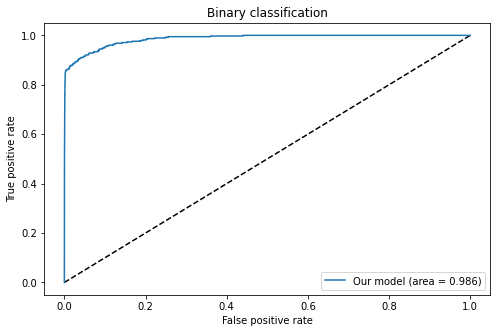

In [183]:
aucf = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Our model (area = {:.3f})'.format(aucf))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Binary classification')
plt.legend(loc='best')
plt.show()